In [1]:
# mount your drive

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [ ]:
# Define paths and parameters
DATASET_PATH = "LA/ASVspoof2019_LA_train/flac"
LABEL_FILE_PATH = "LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins

In [ ]:
labels = {}

with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

X = []
y = []

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH, file_name + ".flac")

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]

    X.append(mel_spectrogram)
    y.append(label)

In [ ]:
X = np.array(X)
y = np.array(y)

X,y

In [ ]:
y_encoded = to_categorical(y, NUM_CLASSES)

In [ ]:
split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y_encoded[:split_index], y_encoded[split_index:]

In [ ]:
# Define CNN model architecture
input_shape = (N_MELS, X_train.shape[2], 1)  # Input shape for CNN (height, width, channels)
model_input = Input(shape=input_shape)

In [ ]:
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
model_output = Dense(NUM_CLASSES, activation='softmax')(x)

In [ ]:
model = Model(inputs=model_input, outputs=model_output)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the Model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
635/635 [==============================] - 125s 194ms/step - loss: 0.8655 - accuracy: 0.8898 - val_loss: 0.6782 - val_accuracy: 0.5757
Epoch 2/10
635/635 [==============================] - 127s 199ms/step - loss: 0.1696 - accuracy: 0.9287 - val_loss: 1.2812 - val_accuracy: 0.2926
Epoch 3/10
635/635 [==============================] - 127s 199ms/step - loss: 0.1261 - accuracy: 0.9503 - val_loss: 1.3782 - val_accuracy: 0.3820
Epoch 4/10
635/635 [==============================] - 129s 203ms/step - loss: 0.0902 - accuracy: 0.9663 - val_loss: 3.0074 - val_accuracy: 0.2179
Epoch 5/10
635/635 [==============================] - 118s 186ms/step - loss: 0.0537 - accuracy: 0.9809 - val_loss: 2.4005 - val_accuracy: 0.2374
Epoch 6/10
635/635 [==============================] - 125s 197ms/step - loss: 0.0393 - accuracy: 0.9877 - val_loss: 5.1723 - val_accuracy: 0.2266
Epoch 7/10
635/635 [==============================] - 127s 199ms/step - loss: 0.0264 - accuracy: 0.9911 - val_loss: 5.7586 -

In [ ]:
# saving the model
model.save("audio_classifier.h5")

--------
## Visualisation

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Load the model and preprocess test data (similar to training data preprocessing)
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model

In [ ]:
# Define paths and parameters
TEST_DATASET_PATH = "./TestEvaluation"
MODEL_PATH = "audio_classifier.h5"  # Replace with the actual path to your saved model
SAMPLE_RATE = 16000
DURATION = 5
N_MELS = 128
MAX_TIME_STEPS = 109

In [ ]:
# Load the saved model
model = load_model(MODEL_PATH)

In [ ]:
# Load and preprocess test data using librosa
X_test = []

test_files = os.listdir(TEST_DATASET_PATH)
for file_name in test_files:
    file_path = os.path.join(TEST_DATASET_PATH, file_name)

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]

    X_test.append(mel_spectrogram)

# Convert list to numpy array
X_test = np.array(X_test)

# Predict using the loaded model
y_pred = model.predict(X_test)

# Convert probabilities to predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

y_pred

1/1 [==============================] - 0s 52ms/step


array([[9.9999994e-01, 1.5350160e-08],
       [6.7513778e-05, 9.9993247e-01],
       [9.9999994e-01, 1.4381893e-36],
       [9.9999994e-01, 2.0382490e-08],
       [1.1657409e-02, 9.8834246e-01],
       [9.9999994e-01, 8.2560174e-12],
       [3.1591469e-05, 9.9996835e-01],
       [9.9999994e-01, 3.2609187e-33],
       [1.2672208e-03, 9.9873275e-01],
       [6.8567568e-03, 9.9314320e-01]], dtype=float32)

In [ ]:
# Get True Labels

# Path to the ASVspoof 2019 protocol file
PROTOCOL_FILE_PATH = "test_eval.txt"

# Dictionary to store true labels for each file
true_labels = {}

# Read the protocol file
with open(PROTOCOL_FILE_PATH, 'rb') as protocol_file:
    lines = protocol_file.read().decode('utf-8').splitlines()
    print(lines)

for line in lines:
    line = line.strip()  # Strip leading/trailing whitespace
    parts = line.split()
    if len(parts) > 1:  # Check if line has enough parts to extract label
        file_name = parts[0]
        label = parts[-1]  # Last part contains the label
        true_labels[file_name] = label

# Now 'true_labels' contains the true labels for each file
true_labels

['LA_0044 LA_E_1000147 - A10 spoof', 'LA_0067 LA_E_2267312 - - bonafide', 'LA_0020 LA_E_1007069 - A09 spoof', 'LA_0047 LA_E_9521934 - A16 spoof', 'LA_0018 LA_E_5169845 - - bonafide', 'LA_0032 LA_E_2601971 - A16 spoof', 'LA_0042 LA_E_4785445 - - bonafide', 'LA_0006 LA_E_4065507 - A11 spoof', 'LA_0013 LA_E_1644479 - A19 spoof', 'LA_0048 LA_E_4453325 - A17 spoof']


{'LA_0044': 'spoof',
 'LA_0067': 'bonafide',
 'LA_0020': 'spoof',
 'LA_0047': 'spoof',
 'LA_0018': 'bonafide',
 'LA_0032': 'spoof',
 'LA_0042': 'bonafide',
 'LA_0006': 'spoof',
 'LA_0013': 'spoof',
 'LA_0048': 'spoof'}

In [ ]:
y_true = np.array([1 if label == "bonafide" else 0 for label in true_labels.values()]) # y_true are the true labels for each file
y_true

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0])

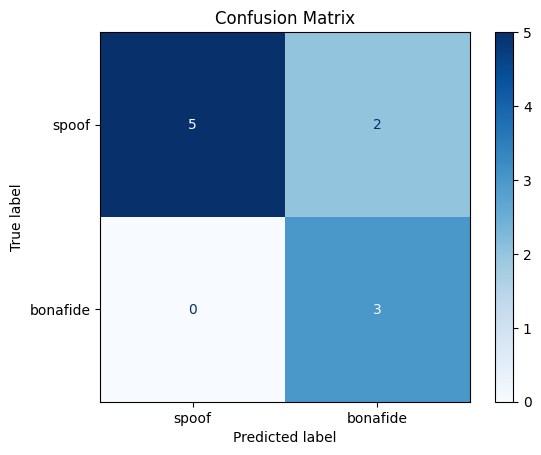

In [ ]:
# CONFUSION MATRIX

cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
classes = ["spoof", "bonafide"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

1/1 [==============================] - 0s 22ms/step


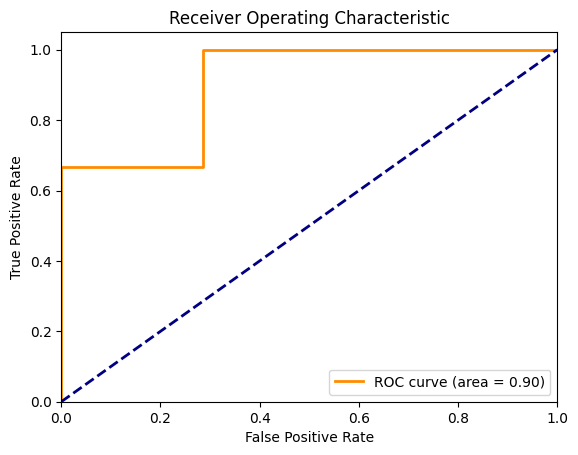

In [ ]:
# ROC Curve

from sklearn.metrics import roc_curve, auc

# Predict using the loaded model
y_pred = model.predict(X_test)

# Get the predicted probabilities for the positive class
y_pred_prob = y_pred[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

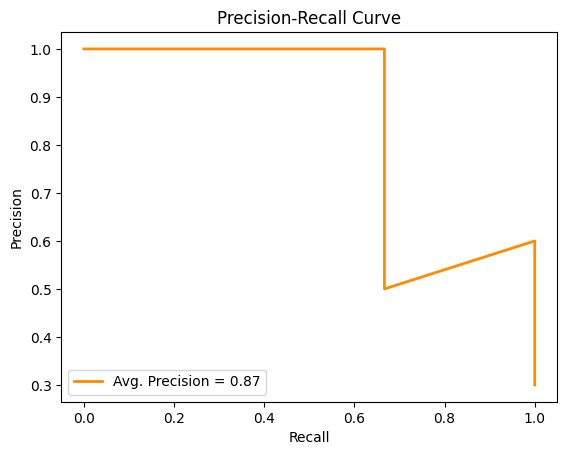

In [ ]:
# Compute precision-recall curve and average precision score
precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
avg_precision = average_precision_score(y_true, y_pred_prob)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='Avg. Precision = %0.2f' % avg_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [ ]:
# Calibration Curve
from sklearn.calibration import calibration_curve

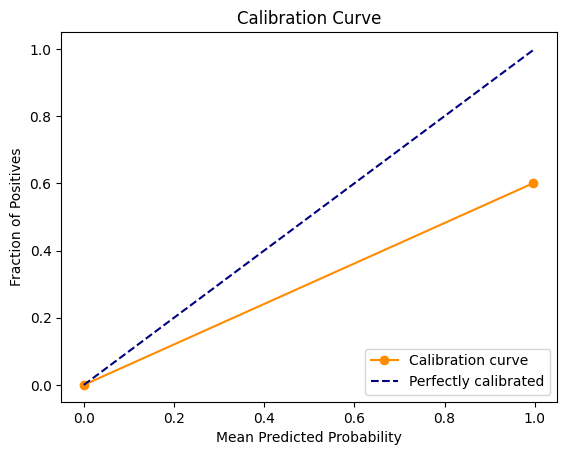

In [ ]:
# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_true, y_pred_prob, n_bins=10)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc="lower right")
plt.show()

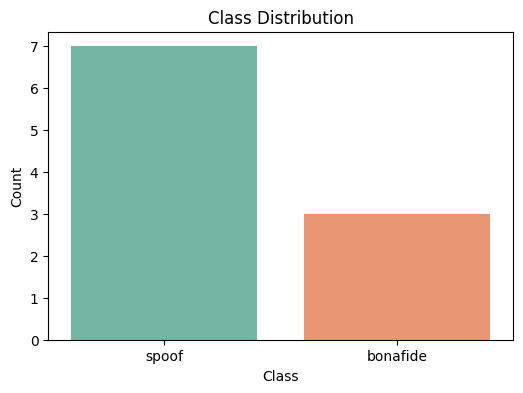

In [ ]:
# Plot bar chart of class distribution

import seaborn as sns
import matplotlib.pyplot as plt


LABELS = ['spoof', 'bonafide']

plt.figure(figsize=(6, 4))
sns.countplot(x=y_true, palette="Set2")
plt.xticks(ticks=[0, 1], labels=LABELS)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

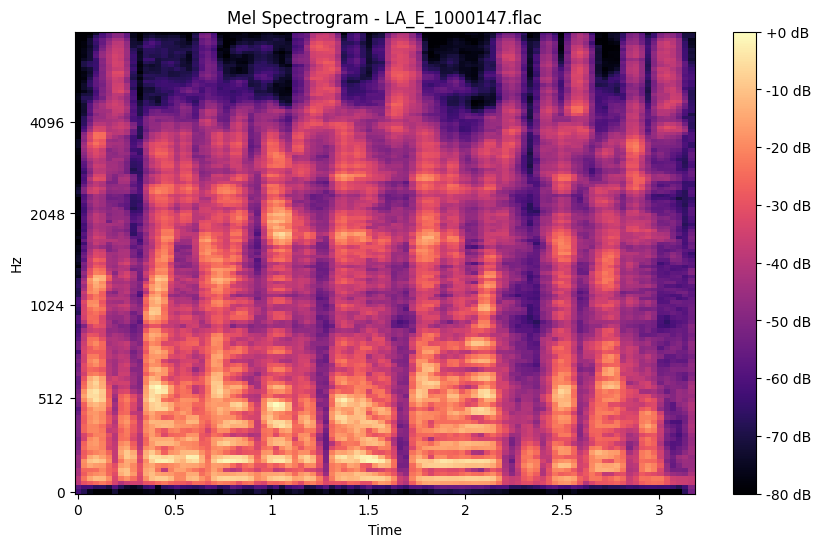

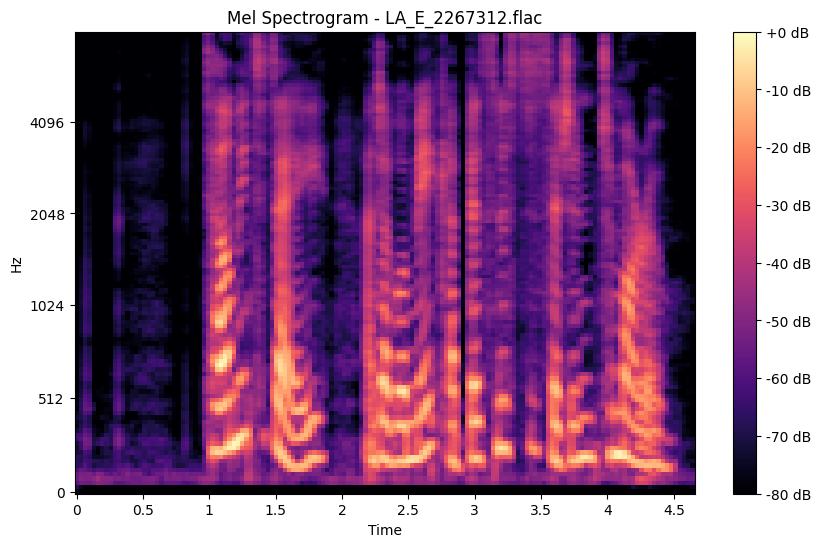

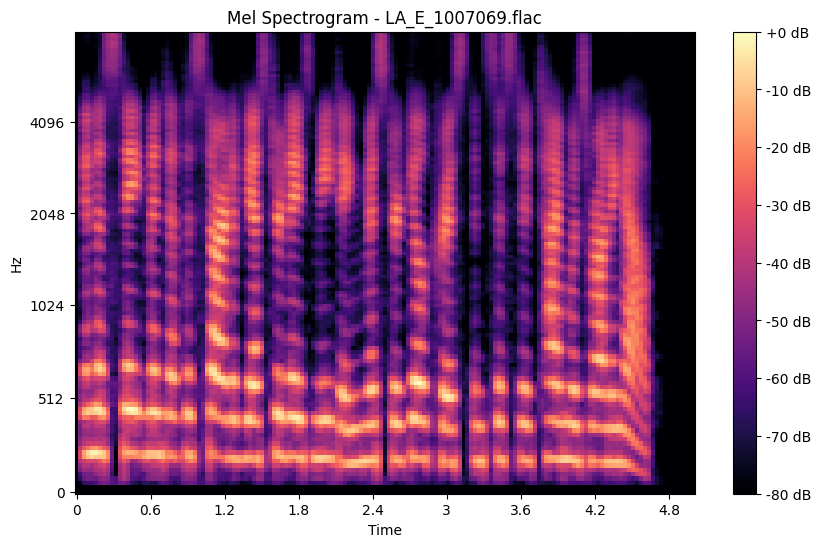

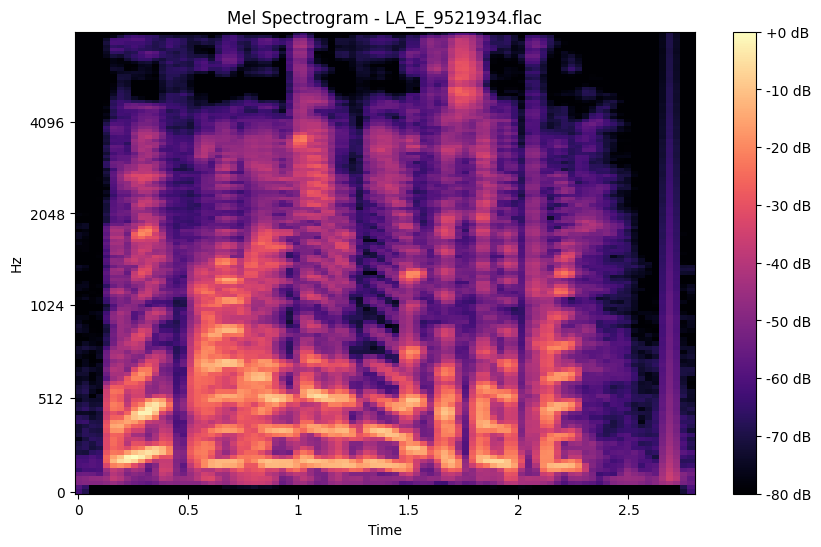

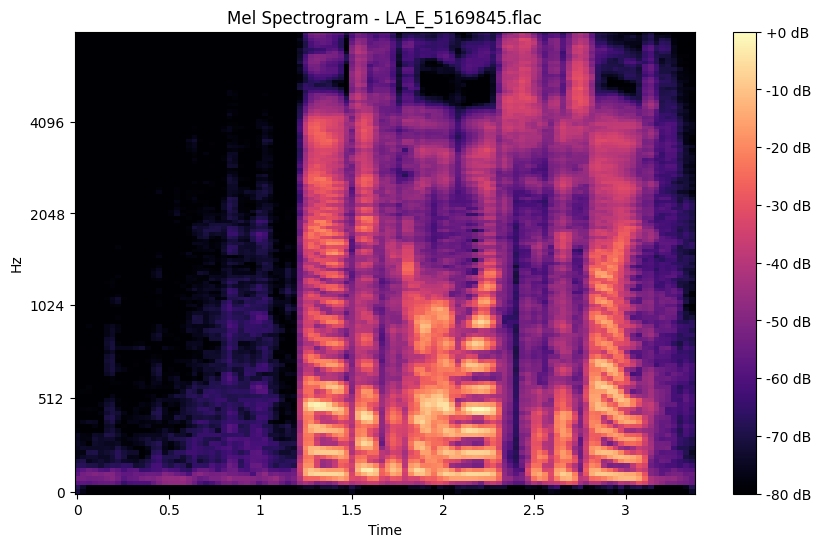

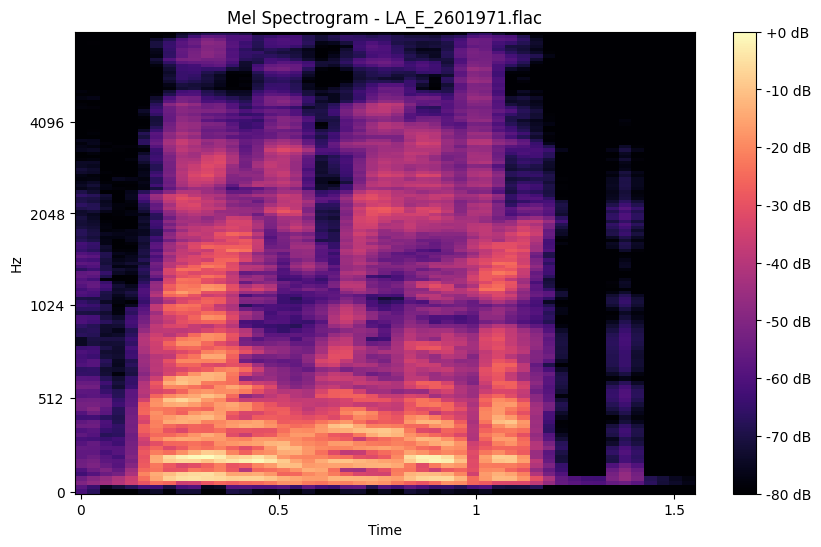

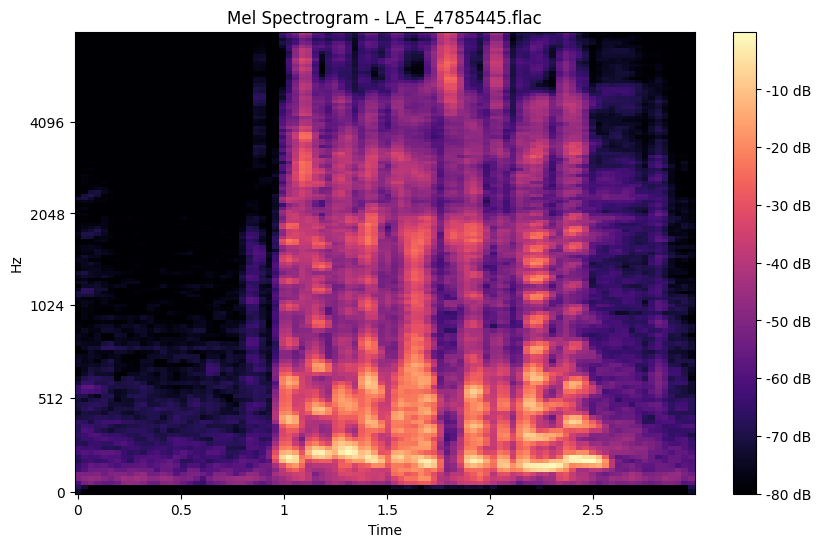

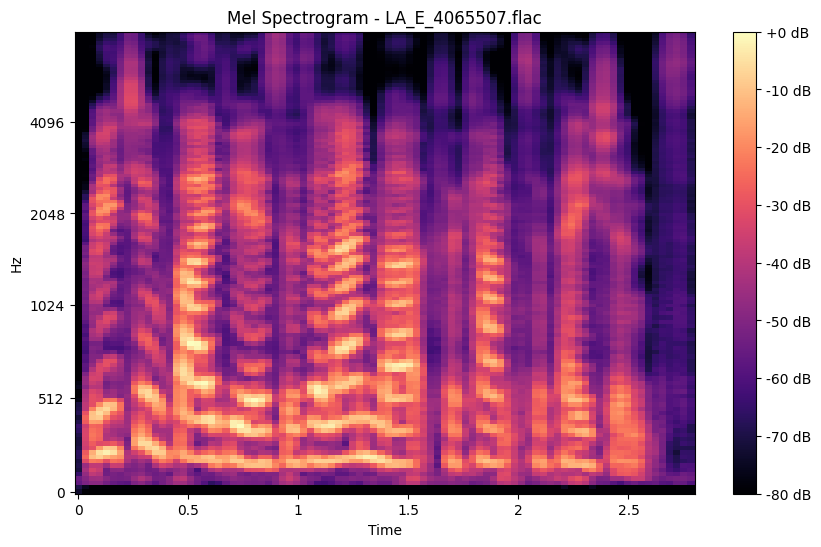

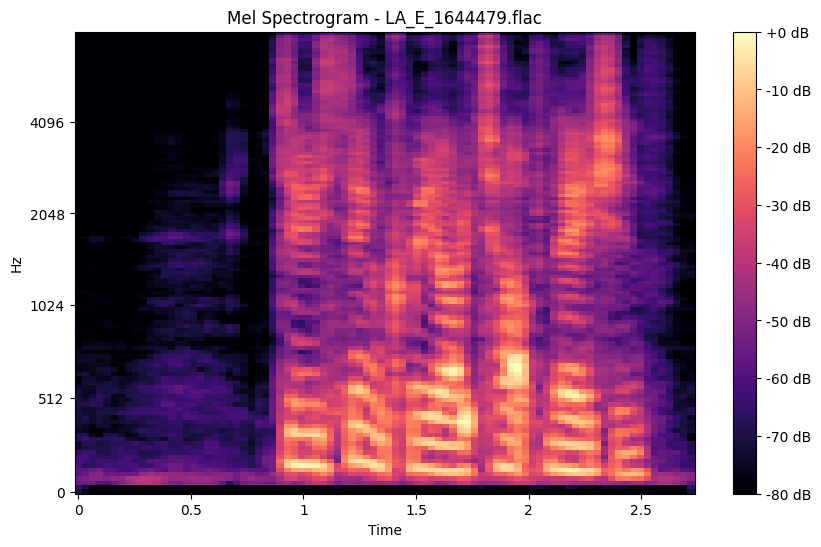

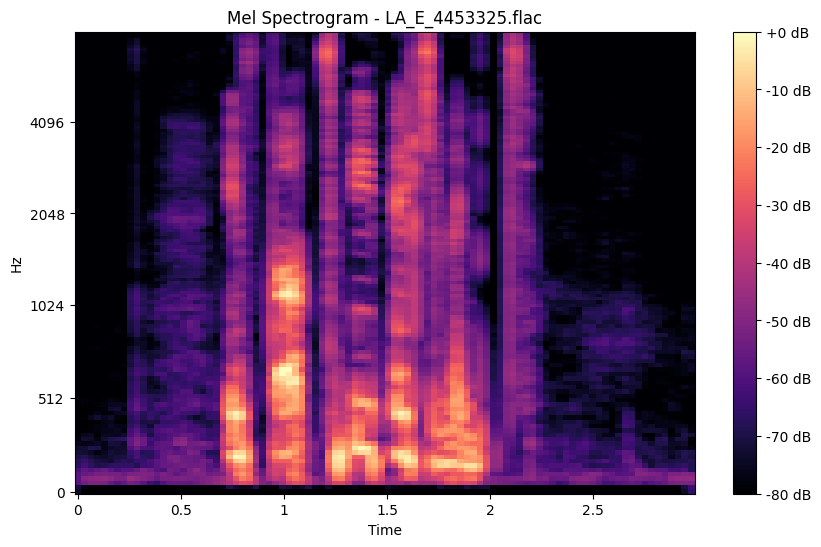

In [ ]:
# Visualising Mel Spectrogram

import os
import librosa.display

# Folder containing .flac audio files
folder_path = "TestEvaluation"

# Get a list of all .flac files in the folder
flac_files = [file for file in os.listdir(folder_path) if file.endswith(".flac")]

# Define the hop length
HOP_LENGTH = 512  # Adjust this value based on your needs

# Loop through each .flac file and visualize its Mel spectrogram
for flac_file in flac_files:
    audio_file_path = os.path.join(folder_path, flac_file)

    # Load the audio file using librosa
    audio, _ = librosa.load(audio_file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Calculate the Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Plot the Mel spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram - {flac_file}')
    plt.show()


In [4]:
!pip install graphviz pydot

In [9]:
from keras.utils import plot_model
import tensorflow as tf

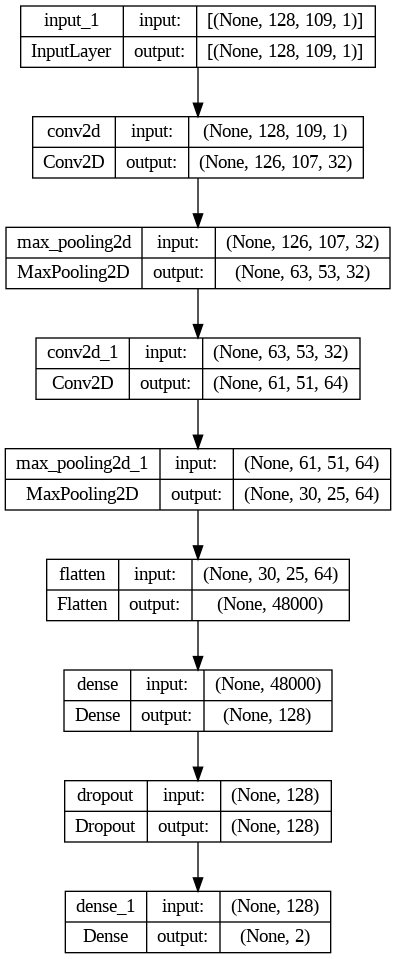

In [10]:
mod = tf.keras.saving.load_model("/content/drive/MyDrive/iit-guwahati/audio_classifier.h5")
plot_model(mod, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)